# EX-10-June-2024-Analysis

## Set up

In [31]:
# Standard python imports
import umap                     # dimension reduction
import pandas as pd             # working with tables & spreadsheets
import numpy as np              # working with matrices & numbers
import seaborn as sns           # visualization
import matplotlib.pyplot as plt # visualization

In [95]:
# Packages for working with text and embeddings
from langchain.embeddings import HuggingFaceEmbeddings # Embedding text to vectors

In [96]:
# Load results from experiment
dfLLM = pd.read_csv('EX-10-JUNE-2024-LLM-llama3-70b.csv')
dfRAG = pd.read_csv('EX-10-JUNE-2024-RAG-llama3-70b.csv')

# Represent Prompts as Vectors

In [97]:
# Load the embedder model
embedder = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')

/home/oliven/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [98]:
dfRAG['prompt'] # This is how you see all the prompts

0       Gene regulation is often described from the pe...
1       Gene regulation is often described from the pe...
2       Gene regulation is often described from the pe...
3       Gene regulation is often described from the pe...
4       Gene regulation is often described from the pe...
                              ...                        
2065    In nonlinear control theory, there are differe...
2066    In nonlinear control theory, there are differe...
2067    In nonlinear control theory, there are differe...
2068    In nonlinear control theory, there are differe...
2069    In nonlinear control theory, there are differe...
Name: prompt, Length: 2070, dtype: object

In [99]:
uniquePrompts = list(dfRAG['prompt'].unique()) # Get the unique prompts

In [100]:
# convert each prompt to an embedding
embeddings = []
for prompt in uniquePrompts:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)

In [101]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = uniquePrompts

/home/oliven/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [102]:
# makde some new columns in umap dataframe for number of words and length of each prompt
udf['len'] = udf['Prompt'].str.len()
udf['nwords'] = udf['Prompt'].str.split(' ').apply(len)

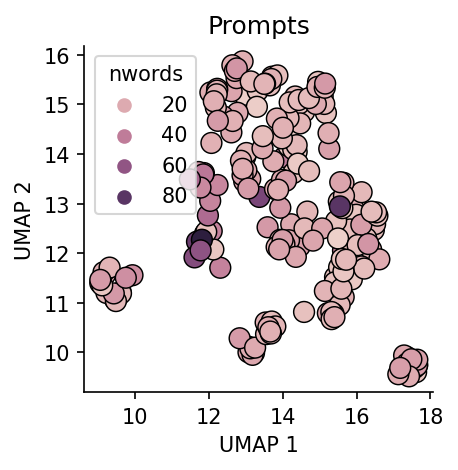

In [103]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks()
plt.yticks()
sns.despine()
plt.show()


In [104]:
# What is this outlying cluster?
udf[(udf['UMAP 1'] > 16)  & (udf['UMAP 2'] < 11)]

# Ah it is the set of prompts related to math

,UMAP 1,UMAP 2,Prompt,len,nwords
6,17.364492,9.903446,Upon introduction of exogenous MYOD to a fibro...,352,52
7,17.285778,9.935899,Weintraub discovered the importance of MYOD in...,173,21
52,17.591747,9.666002,Where does myod bind?,21,4
53,17.610926,9.600180,What are the targets and first order interacti...,58,10
73,17.642185,9.747226,What is the significance of MyoD as a master r...,126,20
74,17.562159,9.681122,How does the use of a retroviral long terminal...,122,20
75,17.413710,9.614609,What methodologies were employed to introduce ...,178,26
76,17.633968,9.730041,In what ways did the expression of MyoD lead t...,173,27
77,17.643459,9.850128,How did MyoD expression affect differentiated ...,169,24
78,17.366928,9.774562,What evidence supports the conclusion that Myo...,161,23


In [145]:
###This is my shenanigans -N
## taking out all prompts with myod and then adding one back in to see if its still an outlier (it is not)
#Taking out the word MyoD to see if it still clusters
filtered_df = udf
filtered_words = ["MyoD", "myod", "MYOD", "myOD"]

for word in filtered_words:
    prompts_with_keywords = filtered_df[filtered_df.apply(lambda row: row.astype(str).str.contains(word, case=False).any(), axis=1)]
for word in filtered_words:
    filtered_df = filtered_df[~filtered_df.apply(lambda row: row.astype(str).str.contains(word).any(), axis=1)]
    # Select one prompt that contains any of the keywords to add back
  
# Check if there is at least one prompt with the keywords
if not prompts_with_keywords.empty:
    # Select the first prompt with the keywords to add back
    prompt_to_add_back = prompts_with_keywords.iloc[0]
    
    # Insert the selected prompt back into the filtered DataFrame
    # Here, we add it back to the end; you can modify this to insert it at a specific index if needed
    filtered_df = pd.concat([filtered_df, prompt_to_add_back.to_frame().T], ignore_index=True)


filtered_df.to_csv('filtered_output_6_11_test_3.csv', index=False)

filtered_csv = pd.read_csv('filtered_output_6_11_test_3.csv')
filtered_prompts = list(filtered_csv['Prompt'].unique()) # Get the unique prompts



In [146]:
# make a new embedding now that stuff was removed
embeddings = []
for prompt in filtered_prompts:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)

# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

#filtered_df = pd.DataFrame()           # save umap results to the dataframe we made earlier
filtered_csv['UMAP 1'] = embedding[:,0]
filtered_csv['UMAP 2'] = embedding[:,1]
filtered_csv['Prompt'] = filtered_prompts




/home/oliven/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/oliven/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Figure size 640x480 with 0 Axes>

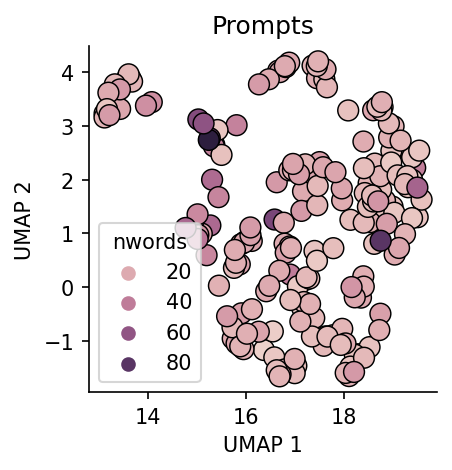

In [147]:
# visualize the prompt embeddings
plt.clf()
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=filtered_csv,
                x='UMAP 1',
                y='UMAP 2',
                hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks()
plt.yticks()
sns.despine()
plt.show()

In [125]:
# Are our embeddings case sensitive? Do we care if we take out commas and punctuation and all the fun stuff?
# If this doesn't mess stuff up, since we are using the same embeddings on the database itself we an also assume this of that

In [148]:
# What is this outlieing cluster?
filtered_df[(filtered_df['UMAP 1'] < 15)  & (filtered_df['UMAP 2'] > 3)]

,UMAP 1,UMAP 2,Prompt,len,nwords
0,11.890114,12.390557,Gene regulation is often described from the pe...,382,58
1,12.304127,11.705609,Compare and contrast the utility of dynamical ...,257,37
2,13.362659,13.134395,Synthetic lethality occurs when the knockout o...,402,69
3,14.043444,13.939113,The addition of transcription factors have bee...,245,40
4,13.586426,12.522553,RNAi is used to silence different genes. How l...,153,27
...,...,...,...,...,...
189,11.844213,13.589692,Chromatin conformation capture methods are one...,273,42
190,11.767829,13.32303,I recently completed my Hi-C experiment and ha...,186,34
191,11.479575,13.488912,"Often, Hi-C data from chromatin conformation c...",326,50
192,9.924908,11.554383,"In nonlinear control theory, there are differe...",191,31


# Responses from LLM Only

In [54]:
# convert each prompt to an embedding
embeddings = []
for prompt in dfLLM['response-0']:
    embeddings.append(embedder.embed_query(prompt))
for prompt in dfLLM['response-1']:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)
print(embeddings.shape)

(384, 768)


In [55]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = list(dfLLM['response-0']) + list(dfLLM['response-1'])

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


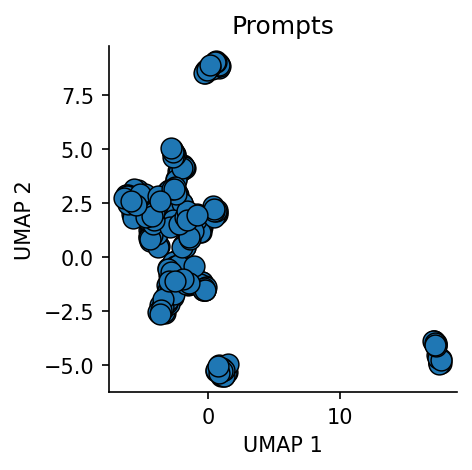

In [60]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                #hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
#plt.yticks([])
sns.despine()
plt.show()

In [64]:
udf[(udf['UMAP 2'] < -4) & (udf['UMAP 1'] < 3)]

,UMAP 1,UMAP 2,Prompt
6,1.432011,-5.311302,I don't know the exact relationship between th...
7,1.146505,-5.324695,"According to the context, Harold Weintraub's d..."
11,0.641910,-5.260585,I don't know the specific transcription factor...
52,1.078184,-5.399102,MyoD is a transcription factor that binds to s...
53,1.093116,-5.190405,I don't know the specific targets and first-or...
73,1.197696,-5.390396,MyoD is a master regulatory gene that plays a ...
74,1.403552,-5.129912,I don't know the answer to this question. The ...
75,1.435755,-5.008493,"According to the available literature, several..."
76,1.063877,-5.210805,I don't know the specific answer to this quest...
77,1.227828,-5.504432,I don't know the specific effects of MyoD expr...


In [61]:
udf[udf['UMAP 2'] > 7]

,UMAP 1,UMAP 2,Prompt
174,0.777028,8.943130,"Unfortunately, I don't know of a specific meth..."
175,0.765376,8.834894,The Kronecker product and the tensor product a...
176,0.417849,8.741407,A graph product is a way of combining two grap...
177,0.836562,8.874559,"The Kronecker decomposition, also known as the..."
178,0.864916,8.746962,The Kronecker product! It's a mathematical ope...
179,0.765629,8.839939,What a great question!\n\nThe Kronecker produc...
180,-0.020950,8.682843,Simplicial complexes and hypergraphs are both ...
181,-0.085536,8.640036,I don't know the exact relationship between dy...
182,0.631678,9.037052,Tensor eigenvalues and matrix eigenvalues are ...
183,0.580219,9.018688,"Yes, there is a relationship between eigenvalu..."


In [59]:
udf[udf['UMAP 1'] > 10]

,UMAP 1,UMAP 2,Prompt
23,17.579493,-4.770941,I don't know.
62,17.122953,-3.906010,I don't have enough information to provide a s...
67,17.574654,-4.850346,I don't know.
105,17.530663,-4.839203,I don't know.
111,17.590445,-4.831063,I don't know.
112,17.137541,-3.913377,I don't have enough information to provide a s...
115,17.322298,-4.035203,I don't know the answer to this question as it...
127,17.531555,-4.798528,I don't know.
135,17.392286,-4.555184,"I don't know. The provided context is empty, a..."
137,17.717152,-4.706528,I don't know.
